In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

/Users/adamschiller/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'
CSV = PATH/'words.csv'

# !ls {PATH}

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Helper Functions

In [5]:
def char_label_text(pred):
    ints = to_np(pred).astype(int)
    ints = ints[np.nonzero(ints)]
    return ''.join([itos[i] for i in ints])

def word_label_text(pred):
    ints = to_np(pred).astype(int)
    ints = ints[np.nonzero(ints)]
    return ' '.join([w_itos[i] for i in ints])

In [6]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    if title: ax.set_title(title)
    return ax

# Data

In [7]:
itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))

### 3x1

In [8]:
fname = 'synth_words_50000.csv' if device.type == 'cuda' else 'synth_words.csv'
CSV = PATH/fname
FOLDER = 'synth_words'
# char_csv.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

csv = pd.read_csv(CSV)
len(csv)

10000

In [9]:
seq_len = 45
stats = (np.array([0.90382, 0.90382, 0.90382]), np.array([0.19798, 0.19798, 0.19798]))

### 3x2

In [8]:
fname = 'multi_synth_words_50000.csv' if device.type == 'cuda' else 'multi_synth_words.csv'
CSV = PATH/fname
FOLDER = 'multi_synth_words'

csv = pd.read_csv(CSV)
len(csv)

50000

In [9]:
seq_len = 45 #75
stats = (np.array([0.93186, 0.93186, 0.93186]), np.array([0.17579, 0.17579, 0.17579]))

### Large (1000x1000)

In [8]:
CSV = PATH/'large_synth_words.csv'
FOLDER = 'large_synth_words'

csv = pd.read_csv(CSV)
len(csv)

5000

In [9]:
seq_len = 45 #200
stats = (np.array([0.93186, 0.93186, 0.93186]), np.array([0.17579, 0.17579, 0.17579]))

### Word

In [8]:
w_itos = pickle.load(open(TMP_PATH/'synth_word_itos.pkl', 'rb'))

In [9]:
# 3x1
W_CSV = PATH/'synth_word_ids.csv'
FOLDER = 'synth_words'

# 3x2
# W_CSV = PATH/'multi_synth_word_ids.csv'
# FOLDER = 'multi_synth_words'
# csv.to_csv(CSV, columns=['filename', 'word_ids'], index=False)

w_csv = pd.read_csv(W_CSV)
len(w_csv)

10000

#### Only word testing

In [10]:
itos = w_itos
CSV = W_CSV
csv = w_csv
seq_len = 5

### Get val_idxs

In [11]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

1500

### Calculate normalization stats

In [ ]:
means = []
stds  = []
for filename in os.listdir(PATH/FOLDER):
    im=Image.open(PATH/FOLDER/filename)
    img = np.array(im)
    means.append(img.mean((0,1)))
    stds.append(img.std((0,1)))
    im.close()
    
means = np.stack(means)
stds = np.stack(stds)

In [19]:
stats = (np.array(means.mean(0)/255), np.array(stds.mean(0)/255))
stats

(array([0.93186, 0.93186, 0.93186]), array([0.17579, 0.17579, 0.17579]))

### ModelData object

In [12]:
stats = inception_stats
sz=64
bs=120

# sz = 128
# bs = 100

# sz = 256
# bs = 60

In [13]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

# stats = (np.array([0.90382, 0.90382, 0.90382]), np.array([0.19798, 0.19798, 0.19798]))
tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
# tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
# resizes in the transforms
data = ImageClassifierData.from_csv(PATH, FOLDER, CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)
# loads in the data at full size

In [14]:
# this saves a bit of memory
data = data.resize(512)

In [14]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

#### Verify dataset transforms

In [15]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
imgs = denorm(x)

In [16]:
# check image normalization
reshaped = x.permute(1,0,2,3).contiguous().view(3,-1)
trn_mean = reshaped.mean(1)
trn_std  = reshaped.std(1)
print(f"mean: {trn_mean}\nstd: {trn_std}")

mean: tensor([0.7928, 0.7928, 0.7928])
std: tensor([0.3337, 0.3337, 0.3337])


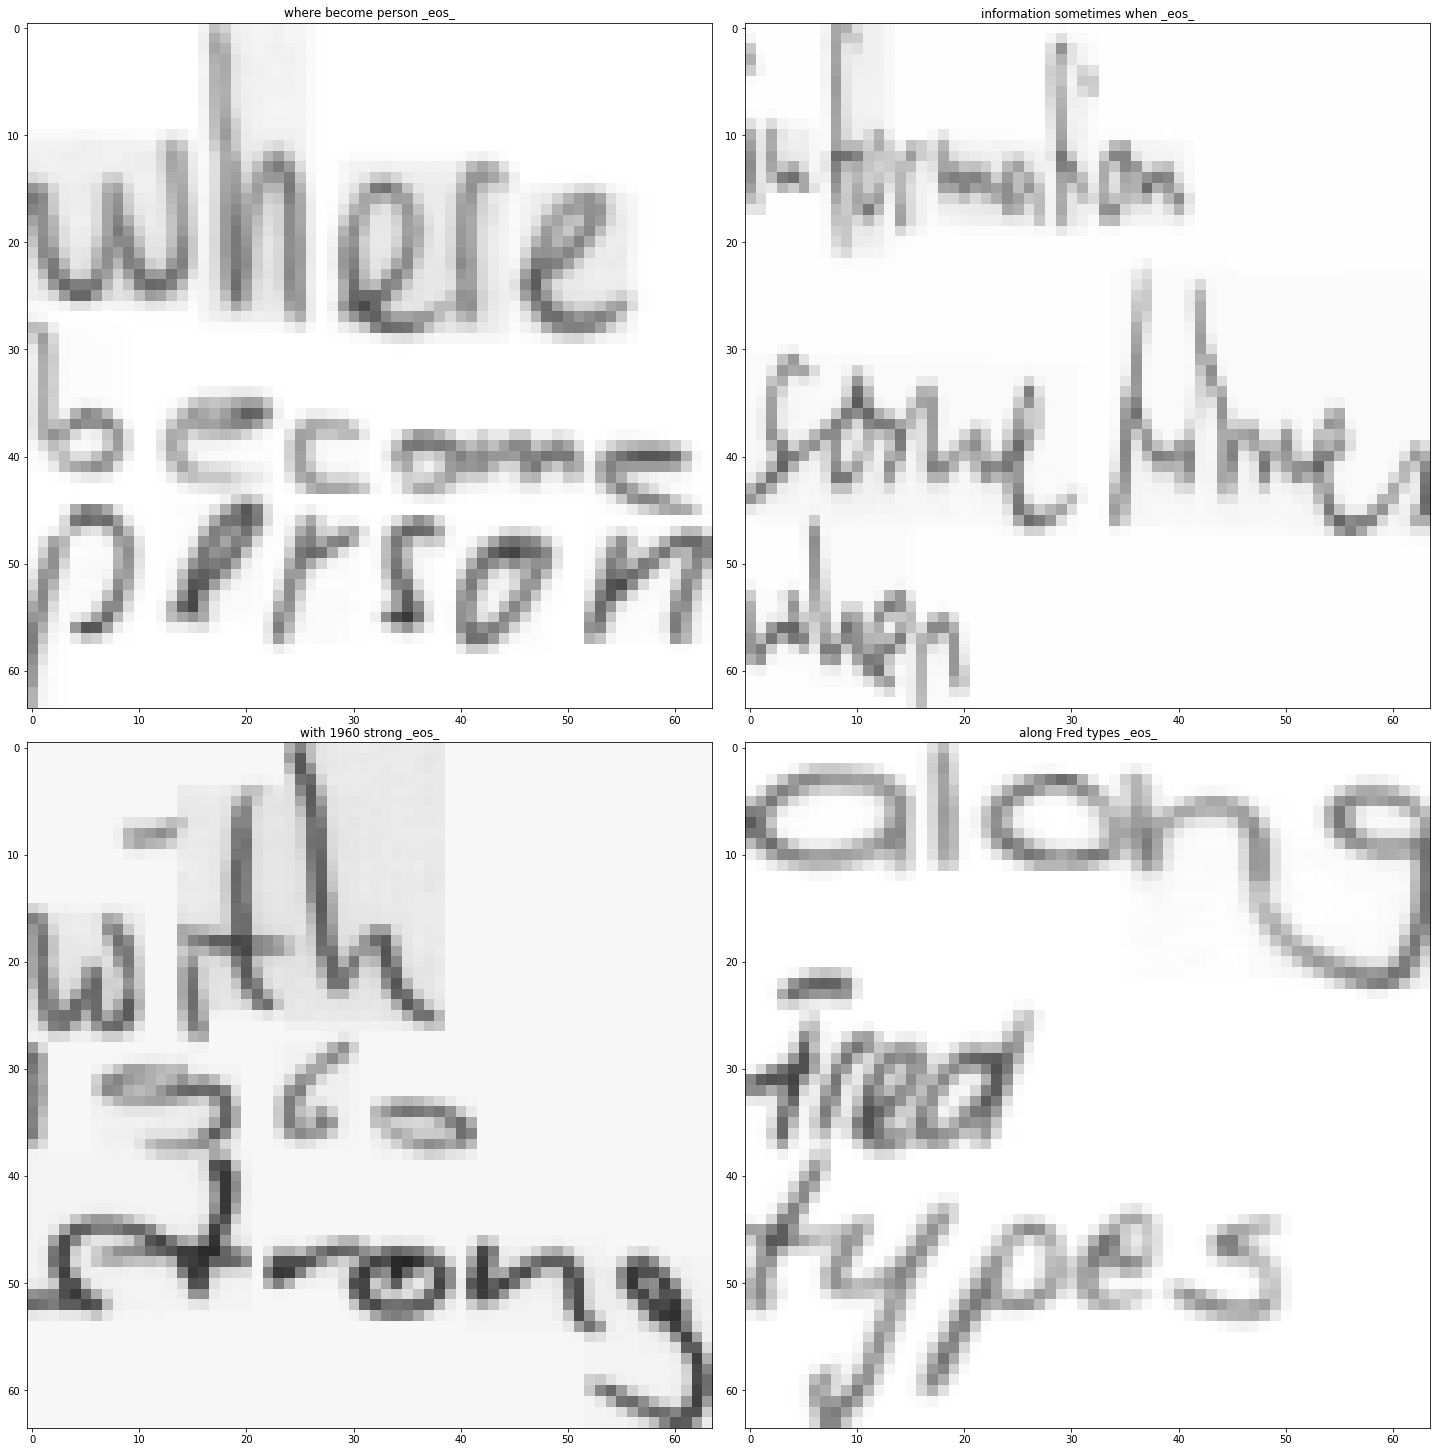

In [17]:
fig, axes = plt.subplots(2,2, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    t = word_label_text(y[i])
    ax=show_img(imgs[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

### Combine word/char datasets

In [16]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [17]:
w_data = ImageClassifierData.from_csv(PATH, FOLDER, W_CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)

In [18]:
trn_ds = ConcatLblDataset(data.trn_ds, w_data.trn_y)
val_ds = ConcatLblDataset(data.val_ds, w_data.val_y)
data.trn_dl.dataset = trn_ds
data.val_dl.dataset = val_ds

In [19]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

#### Verify multi-dataset

In [20]:
denorm = data.trn_ds.ds.denorm   # need the extra .ds when using ConcatLblDataset
_,(y0,y1) = next(iter(data.trn_dl))

In [21]:
chars = [itos[int(w)] for w in y0[3]]
''.join(chars)

'Tuesday little they that Above called_eos__pad__pad__pad__pad__pad__pad__pad__pad__pad__pad__pad__pad__pad__pad__pad__pad__pad__pad__pad_'

In [22]:
words = [w_itos[int(c)] for c in y1[3]]
' '.join(words)

'Tuesday little they that Above called _eos_'

# Loss and Metrics

In [18]:
# categorical cross entropy loss
# list of probabilities for each word in vocab; target is correct word

def seq2seq_loss(input, target):
    target = target.permute(1,0).contiguous()
    tsl = target.size(0)
    sl,bs,nc = input.size()
    
    if sl>tsl: target = F.pad(target, (0,0,0,sl-tsl))
    if tsl>sl: target = target[:sl]  
#     if tsl>sl: input = F.pad(input, (0,0,0,0,0,tsl-sl))
        
    targ = target.view(-1)
    pred = input.view(-1, nc)

    # combination of LogSoftmax and NLLLoss
    return F.cross_entropy(pred, targ.long(), reduction='sum')/bs

In [19]:
import Levenshtein as Lev

# pulled from Sean Nareen's deepspeech decoder module
# https://github.com/SeanNaren/deepspeech.pytorch/blob/master/decoder.py

def cer(t, p):
    """
    Computes the Character Error Rate, defined as the edit distance.
    Arguments:
        t (string): target space-separated sentence
        p (string): prediction space-separated sentence
    """
    t, p, = t.replace(' ', ''), p.replace(' ', '')
    return Lev.distance(t, p)/len(t)

def wer(s1, s2):
    """
    Computes the Word Error Rate, defined as the edit distance between the
    two provided sentences after tokenizing to words.
    Arguments:
        s1 (string): space-separated sentence
        s2 (string): space-separated sentence
    """

    # build mapping of words to integers
    b = set(s1.split() + s2.split())
    word2char = dict(zip(b, range(len(b))))

    # map the words to a char array (Levenshtein packages only accepts
    # strings)
    w1 = [chr(word2char[w]) for w in s1.split()]
    w2 = [chr(word2char[w]) for w in s2.split()]

    return Lev.distance(''.join(w1), ''.join(w2))/len(w1)

In [20]:
def char_error_rate(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([sl, bs, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = char_label_text(res[:,i])
        t = char_label_text(targs[i])
        error += cer(t,p)
    return error/bs

def word_error_rate(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([sl, bs, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = word_label_text(res[:,i])
        t = word_label_text(targs[i])
        error += wer(t,p)
    return error/bs

### CTC

In [43]:
from warpctc_pytorch import CTCLoss

ctc = CTCLoss(size_average=True)    #normalize loss by batch size

def ctc_loss(input, target):
    target = target.permute(1,0).contiguous()
    tsl = target.size(0)
    sl,bs,nc = input.size() 
    
    inp_lens = torch.full((bs,), sl, dtype=torch.int32)
    
    ##NOTE: inp => gpu, everything else on cpu!!
    
    # need to remove 0s from labels (same as ctc blank character)
    targ = []
    targ_lens = []
    for i in range(bs):
        t = target[:,i]
        # remove 0 padding from targets
        t = t[t.nonzero().squeeze(1)]
        targ.append(t)
        targ_lens.append(len(t))

    targ = torch.cat(targ).type(torch.int32).cpu()
    targ_lens = torch.tensor(targ_lens, dtype=torch.int32)
        
    return ctc(input, targ, inp_lens, targ_lens)
    # inputs: Tensor of (seqLength x batch x vocab_size) containing output activations from network (before softmax)
    # targets: 1 dimensional Tensor containing all the targets of the batch in one large sequence
    # input_lens: Tensor of size (batch) containing size of each output sequence from the network
    # target_lens: Tensor of (batch) containing label length of each example

### Combo word/char

In [59]:
def char_error(preds, targs):
    c_preds,_ = preds
    c_targs,_ = targs
    
    bs,sl = c_targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([sl, bs, vs])
        
    res = torch.argmax(c_preds, dim=2)
    error = 0
    for i in range(bs):
        p = error_label(res[:,i])
        t = error_label(c_targs[i])
        error += cer(t,p)
    return error/bs

def word_error(preds, targs):
    _,w_preds = preds
    _,w_targs = targs
    
    bs,sl = w_targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([sl, bs, vs])
        
    res = torch.argmax(w_preds, dim=2)
    error = 0
    for i in range(bs):
        p = word_error_label(res[:,i])
        t = word_error_label(w_targs[i])
        error += wer(t,p)
    return error/bs/sl

In [39]:
def combo_loss(preds, targs):
    char_loss = ctc_loss(preds[0], targs[0])
    word_loss = seq2seq_loss(preds[1], targs[1])
    return char_loss + word_loss.cpu()

# Xception

In [ ]:
class SeparableConv2d(nn.Module):
    def __init__(self,c_in,c_out,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        # depthwise conv - spatial conv performed independently over every channel of an input
        self.conv1 = nn.Conv2d(c_in,c_in,kernel_size,stride,padding,dilation,groups=c_in,bias=bias)
        # pointwise conv - regular 1x1 conv, projecting channels computed by depthwise conv onto new channel space
        self.pointwise = nn.Conv2d(c_in,c_out,1,1,0,1,1,bias=bias)

    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x

In [22]:
class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None

        self.relu = nn.ReLU(inplace=True)
        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x

In [ ]:
class XceptionBase(nn.Module):
    def __init__(self):
        super(XceptionBase, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, 2, 0, bias=False)      #32
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)    #16
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)    #8
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)    #4

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)   # 64: 4x4x728

#         self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)
#         self.conv3 = SeparableConv2d(1024,1536,3,1,1)
#         self.bn3 = nn.BatchNorm2d(1536)

        #do relu here
#         self.conv4 = SeparableConv2d(1536,2048,3,1,1)
#         self.bn4 = nn.BatchNorm2d(2048)

#         self.fc = nn.Linear(2048, num_classes)

#         self.conv3 = SeparableConv2d(728, 1024, 3, 1, 1)
#         self.bn3 = nn.BatchNorm2d(1024)
        
        # #------- init weights --------
        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        #         m.weight.data.normal_(0, math.sqrt(2. / n))
        #     elif isinstance(m, nn.BatchNorm2d):
        #         m.weight.data.fill_(1)
        #         m.bias.data.zero_()
        # #-----------------------------

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
#         x = self.block12(x)

#         x = self.conv3(x)
#         x = self.bn3(x)
#         x = self.relu(x)

#         x = self.conv4(x)
#         x = self.bn4(x)
        return x

In [50]:
class Net(nn.Module):
    def __init__(self, base, seq_len, vocab):
        super(Net, self).__init__()
        
        self.base = base
        self.conv = SeparableConv2d(728, 1024, 3, 1, 1)
        self.bn   = nn.BatchNorm2d(1024)
        self.drop = nn.Dropout2d(0.4)
        self.pool = nn.AdaptiveAvgPool1d(seq_len)
        self.fc   = nn.Linear(1024, vocab)

    def forward(self, input):
        x = self.base(input)
        x = self.drop(F.relu(self.bn(self.conv(x))))
        x = self.pool(x.flatten(2,3)).permute(0,2,1)
        x = self.fc(x)
        return x.permute(1,0,2).contiguous()   #sl,bs,vocab

In [23]:
zoo_model = torch.utils.model_zoo.load_url('http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth')

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth" to /Users/adamschiller/.torch/models/xception-43020ad28.pth
100%|██████████| 91675053/91675053 [06:15<00:00, 243846.85it/s] 


In [25]:
base = XceptionBase()
base.load_state_dict(zoo_model, strict=False)

In [51]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
net = Net(base, seq_len, len(itos))
# net = ConvnetBuilder(f, 0, 0, True, custom_head=head, xtra_cut=1).model
learn = ConvLearner.from_model_data(to_gpu(net), data, opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [word_error_rate] #[char_error_rate]

In [52]:
learn.freeze_to(-5)

# Arch

In [67]:
# modified for sz: 64

class Encoder(nn.Module):
    def __init__(self, embed_size, drop=0.5):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[embed_size]
        
        net = f(True)
        modules = list(net.children())[:s]
        self.base = nn.Sequential(*modules)
        
#         self.linear0 = nn.Linear(128, embed_size)
        
        #mlp
        self.drop = nn.Dropout(drop)
        self.linear1 = nn.Linear(embed_size, embed_size)
        self.linear2 = nn.Linear(embed_size, embed_size)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()
        
        features = self.base(inp).flatten(2, 3).permute(2, 0, 1)
#         features = self.linear0(features)
        
        # initial hidden is an average of features fed through an MLP
        h = self.drop(features)
        h = self.linear2(F.relu(self.linear1(h))).mean(0)
                        
        return features, h

In [47]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, drop=0.5):
        super().__init__()

        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.drop   = nn.Dropout(drop)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, hidden, feats):
        w1e = self.attn_1(feats)                    # ([64, 30, 256])
        w2h = self.attn_2(hidden)                   # ([30, 256])
        u = self.drop(torch.tanh(w1e + w2h))        # ([64, 30, 256])
        a = torch.softmax(u @ self.attn_v, 0)       # ([64, 30]) - attention mask
        context = (a.unsqueeze(2) * feats).sum(0)   # ([30, 256]) - weighted sum of features w/ attention
        
        return context, a

In [24]:
class RNNDecoder(nn.Module):
    def __init__(self, embed_size, num_layers, drop=0.5):
        super().__init__()
        
        self.num_layers = num_layers
        self.rnn = nn.GRU(embed_size, embed_size, num_layers, dropout=drop)

    def forward(self, context, hidden):
        out, h = self.rnn(context.unsqueeze(0), hidden.expand(self.num_layers, -1, -1).contiguous())
        
        return out[-1]

In [25]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size, drop=0.5):
        super().__init__()
        
        self.w0 = nn.Linear(embed_size, embed_size)
        self.w1 = nn.Linear(embed_size, embed_size)
        self.w2 = nn.Linear(embed_size, embed_size)
        self.w3 = nn.Linear(embed_size*3, vocab_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, prev, hidden, context):
        # this is called once for each timestep
        #(30,256)
        a = self.w0(prev)
        b = self.w1(hidden)
        c = self.w2(context)
        out = torch.cat([a,b,c], 1)
        
        return self.w3(self.drop(out))

In [68]:
class Net(nn.Module):
    def __init__(self, hidden_size, vocab_size, seq_len, n_layers=1):
        super(Net, self).__init__()
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.encoder = Encoder(hidden_size)
        self.attn    = Attention(hidden_size)
        self.decoder = RNNDecoder(hidden_size, n_layers)
        self.embed   = nn.Embedding(vocab_size, hidden_size)

        self.output  = DeepOutputLayer(hidden_size, vocab_size)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats, hidden = self.encoder(x)
        
        res,attns = [],[]
        dec_inp = torch.ones(bs, device=device).long()
        
        for i in range(self.seq_len):
            prev = self.embed(dec_inp)
            
            context, a = self.attn(hidden, feats)
            hidden = self.decoder(context, hidden)
            out = self.output(prev, hidden, context)
            
            if (self.seq_len-i)%40==0: hidden = repackage_var(hidden)

            res.append(out)
            attns.append(a)
            dec_inp = out.data.max(1)[1]
            if (dec_inp==0).all(): break

        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

In [69]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(itos), seq_len, 3)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [char_error_rate]

 58%|█████▊    | 41/71 [00:28<00:20,  1.45it/s, loss=233]

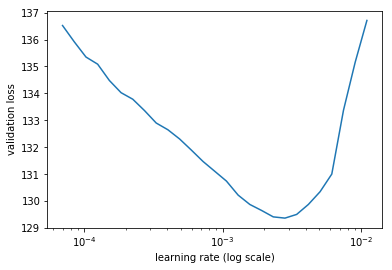

In [30]:
learn.lr_find()
learn.sched.plot(n_skip_end=3)

In [29]:
learn.load('3x2_300')

In [71]:
# lr=1e-4
# learn.fit(lr, 3, cycle_len=1, use_clr_beta=(10,10,0.95,0.85))

lr=1e-3
learn.fit(lr, 4, cycle_len=1, use_clr=(20,4))

# 3x1, sz: 64, sl: 45
# 68.923135  68.804574  0.778221     sz:96, lr:1e-4
# 70.384609  70.11158   0.853604     sz: 64, lr:1e-4 clr_beta, slice: -4    **sz most imp for attn!
# 65.013099  64.089046  0.744029     "", lr:1e-3 clr, ""
# 65.116957  63.882609  0.742186     "", "", "", dropout
# 66.724635  65.784025  0.750741     "", "", "", "", init_hidden            **hidden doesn't make a big difference
# 67.904225  66.286942  0.768866     "", "", "", "", simplified deep output
# 67.210914  68.855696  0.7979       "", "", "", "", mod deep output
# 63.62897   61.755674  0.716586     "", "", "", "", 2 layers
# 63.363833  61.547648  0.726961     "", "", "", "", 2 layers w/ dropout
# 65.447725  64.916475  0.745606     "", "", "", "", 2 layers w/ dropout bidir
# 66.733563  65.220792  0.725245     "", "", "", "", 1 layer bidir
# 61.781128  58.316876  0.671617     "", "", "", "", 3 layers w/ dropout
# 66.353612  65.012771  0.742848     "", "", "", "", 3 layers w/ dropout, uniform embedding weights
# 66.892848  65.19859   0.747121     "", "", "", "", 3 layers w/ dropout, Embedding

# 60.088251  56.6687    0.64367      3 layers w/ dropout; data specific normalization stats
# 51.163667  48.662667  0.517828     2nd run
# 44.073406  43.868489  0.413981     3rd run    ***'experiment'

# 62.052624  59.738692  0.721711     3 layers w/ dropout; data specific normalization stats, emb: 300, slice: -4
# 62.789253  59.835216  0.706824     3 layers w/ dropout; data specific normalization stats, emb: 128, slice: -4

# 50.904495  47.123982  0.4832       "","", sz: 128, emb: 256, 4cycles, clr=(20,4)
# 29.10461   26.629915  0.191563     2nd run
# 20.632274  21.7593    0.134349     3rd run    ***'3x1'

# 3x2, sz: 128, sl: 75
# 134.990034 134.306841 0.831486     lr: 1e-3, slice: -4

# 3x2, sz: 256
# 53.888706  49.706285  0.245318     "","", sl: 45, emb: 256, 4cycles, clr=(20,4), '3x1_256' start    ***'3x2'
# 45.332799  43.42131   0.195473     2nd run
# 40.783752  39.31691   0.174236     3rd run ***'3x2_3'

# large, sz: 256
# 103.571021 97.074811  0.852392     "","", sl: 45, emb: 256, 4cycles, clr=(20,4), '3x2_300' start
# 95.229127  91.874417  0.844883     2nd run
# 174.707923 171.799177 0.79711      3rd run (increase seq_len: 75)
# 236.697037 235.776938 0.753219     4th run (increase seq_len: 100)   ***'large_256'

# 463.519717 458.647024 0.971131     5th run (increase seq_len: 150, modify encoder: 512 slice)     FAIL
# 375.991207 376.376373 0.71594      5th run (increase seq_len: 150)   ***'large_256'

epoch      trn_loss   val_loss   char_error_rate           
    0      386.266657 384.919516 0.736578  
    1      381.357502 379.68654  0.726976                  
    2      377.890343 378.164696 0.716865                  
    3      375.991207 376.376373 0.71594                   


[376.3763732910156, 0.7159403062189591]

In [72]:
learn.save('large_256')

In [42]:
seq_len = 150
learn.model.seq_len = seq_len

In [70]:
learn.load('large_256')

In [65]:
# modify Encoder
# make changes to Encoder then run this cell to update the model without errors

enc_dict = learn.model.encoder.state_dict()
new_enc = to_gpu(Encoder(256))
new_enc.load_state_dict(enc_dict, strict=False)
learn.model.encoder = new_enc

## Increase size

In [27]:
sz = 300
bs = 40

In [31]:
learn.set_data(data)

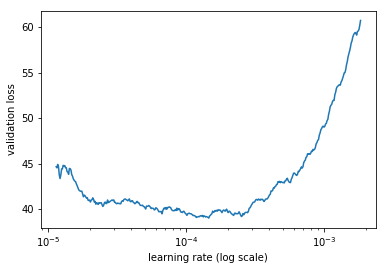

In [33]:
learn.lr_find()
learn.sched.plot()

In [34]:
lr = 1e-4
learn.fit(lr, 4, cycle_len=1, use_clr=(20,4))
# 3x1  
# 26.790512  25.242548  0.171986      3 layers w/ dropout; data specific normalization stats    ***'3x1_128'
# 16.319343  14.249333  0.082034     "","", lr:1e-3, sz:128, emb:256, 4cycles, clr=(20,4)   ***'3x1_256'

# 3x2
# 29.938486  29.298703  0.131659     lr:1e-4, sz: 300, emb: 256, 4cycles, clr=(20,4)    ***'3x2_300'

epoch      trn_loss   val_loss   char_error_rate              
    0      39.265649  34.500624  0.155114  
    1      35.813757  31.3583    0.142607                     
    2      32.350043  30.051244  0.137183                     
    3      29.938486  29.298703  0.131659                     


[29.298703335701152, 0.13165944693805312]

In [35]:
learn.save('3x2_300')

# Baseline - resnet/custom head

In [29]:
class Head(nn.Module):
    def __init__(self, em_sz, seq_len, vocab_size, drop=0.3):
        super().__init__()
        
        self.pool = nn.AdaptiveMaxPool1d(seq_len)
        self.fc1  = nn.Linear(em_sz, em_sz*4)
        self.fc2  = nn.Linear(em_sz*4, vocab_size)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.pool(x.flatten(2,3)).permute(0,2,1)
        x = self.fc2(self.drop(F.relu(self.fc1(x))))
        return x.permute(1,0,2).contiguous()

In [30]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
head = Head(256, seq_len, len(itos))
net = ConvnetBuilder(f, 0, 0, True, custom_head=head, xtra_cut=1).model
learn = ConvLearner.from_model_data(to_gpu(net), data, opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [word_error_rate] #[char_error_rate]

# Baseline w/ attention

In [56]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, drop=0.5):
        super().__init__()

        self.attn_1 = nn.Conv2d(embed_size, embed_size, 1)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.drop   = nn.Dropout(drop)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, feats, hidden):
        w1e = self.attn_1(feats).permute(2,3,0,1)     # ([h, w, bs, 256])
        w2h = self.attn_2(hidden)                     # ([bs, 256])
        u = self.drop(torch.tanh(w1e + w2h))          # ([h, w, bs, 256])
        a = torch.softmax(u @ self.attn_v, 2)         # ([h, w, bs]) - attention mask   
        context = (a.unsqueeze(-1) * feats.permute(2,3,0,1)) # ([bs, 256])  - weighted sum of features w/ attention
        return context.flatten(0,1).sum(0), a

In [57]:
def base_resnet(em_sz, f):
    slices = {128: -4, 256: -3, 512: -2}
    s = slices[em_sz]
    net = f(True)
    return nn.Sequential(*list(net.children())[:-4])

class Net(nn.Module):
    def __init__(self, em_sz, seq_len, vocab_size, drop=0.3):
        super(Net, self).__init__()
        self.seq_len = seq_len
        
        self.base = base_resnet(em_sz, f)
        self.adaptor = nn.Conv2d(128, em_sz, 1)
        
        self.attention = Attention(em_sz)
        
        self.embed   = nn.Embedding(vocab_size, em_sz)
        self.drop    = nn.Dropout(drop)

        self.fc1  = nn.Linear(em_sz, em_sz*4)
        self.fc2  = nn.Linear(em_sz*4, vocab_size)
        self.fc_d = nn.Dropout(drop)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats = self.adaptor(self.base(x))   # (bs, 256, h, w)
        hidden = feats.flatten(2,3).mean(-1) # (bs, 256)
                
        res,attns = [],[]
        
        for i in range(self.seq_len):
            context, a = self.attention(feats, hidden)
            out = self.fc2(F.relu(self.fc1(self.fc_d(context))))
            
            res.append(out)
            attns.append(a)
            hidden = self.drop(self.embed(out.data.max(1)[1]))
            
        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

In [58]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
net = Net(256, seq_len, len(itos))
learn = ConvLearner.from_model_data(to_gpu(net), data, opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [word_error_rate]

In [ ]:
lr=1e-3
learn.fit(lr, 5, cycle_len=1, use_clr_beta=(10,10,0.95,0.85))
# use_clr_beta: (ratio btw initial chosen lr, % of cycle on slow decrease, *momentum values)

# 28.52144   27.718629  0.67499     attention
# 21.272572  20.69161   0.592019    2nd run

#       sequential attention; simple fc out

In [35]:
learn.save('baseline_attn')

# Baseline - rnn

In [27]:
def base_resnet(em_sz, f):
    slices = {128: -4, 256: -3, 512: -2}
    s = slices[em_sz]
    net = f(True)
    return nn.Sequential(*list(net.children())[:s])

class Net(nn.Module):
    def __init__(self, em_sz, seq_len, vocab_size, drop=0.3):
        super().__init__()

        self.base = base_resnet(em_sz*2, f)
        self.pool = nn.Linearar(seq_len)

        self.rnn = nn.GRU(em_sz, em_sz)
        
        self.fc1  = nn.Linear(em_sz, em_sz*4)
        self.fc2  = nn.Linear(em_sz*4, vocab_size)
        
        self.drop = nn.Dropout(drop)

    def forward(self, x, ret_attn=False):
        feats = self.base(x).flatten(2,3)     #bs,hidden,h*w
        out   = self.pool(feats)              #bs,hidden,seq
        
        out, h = self.rnn(out.permute(2,0,1), out)
        
        out = self.fc2(self.drop(F.relu(self.fc1(out))))
        out = out.permute(1,0,2).contiguous()
        if ret_attn: out = out,attn
        return out

In [ ]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
net = Net(256, seq_len, len(itos))
learn = ConvLearner.from_model_data(to_gpu(net), data, opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [word_error_rate]

In [ ]:
lr=1e-3
learn.fit(lr, 5, cycle_len=1, use_clr_beta=(10,10,0.95,0.85))
# use_clr_beta: (ratio btw initial chosen lr, % of cycle on slow decrease, *momentum values)



# Train - Words

 83%|████████▎ | 59/71 [04:47<00:52,  4.35s/it, loss=83.1]

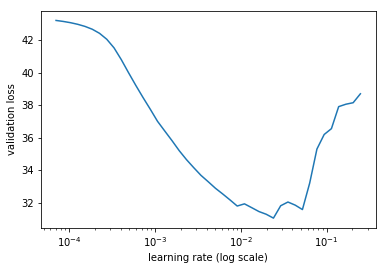

In [31]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=5e-3
learn.fit(lr, 4, cycle_len=1, use_clr=(20,4))

# cpu; 10,000
# 20.726831  21.221216  0.654  --- baseline-resnet34       ** not training! **
# 22.660898  21.534648  0.6575 --- Xception

In [27]:
lr=4e-3
learn.fit(lr, 5, cycle_len=1, use_clr_beta=(10,10,0.95,0.85))
# use_clr_beta: (ratio btw initial chosen lr, % of cycle on slow decrease, *momentum values)

# (3x2) sz:128, 50,000
# 15.190993  13.448569  3.217467      Baseline (no attn)     - baseline
# 6.592356   6.297714   1.688         2nd run (~12min)

# 18.815987  16.850847  3.6789        Baseline (resnet - 512)
# 9.375152   8.614126   2.207067      2nd run (~10min)

# 1544.492761 1452.823649 3.084533    CTC loss (~11min)
# 780.755029 897.458031 2.285733      2nd run (~11min)

# 35.315192  34.958913  5.200267      Darknet w/ SeqConvAttn - darknet_attn
# 43.352003  43.168126  5.288133      Arch                   - arch_attn  XXX

epoch      trn_loss   val_loss   word_error_rate                
    0      1348.680782 1262.901956 2.910933  
    1      1129.468657 1116.729368 2.613867                     
    2      995.638273 1017.155671 2.507333                      
    3      877.223489 946.691742 2.3188                         
    4      780.755029 897.458031 2.285733                  



[array([897.45803]), 2.2857333333333334]

In [82]:
learn.save('baseline')

# Train - Chars

## Size - 64

In [24]:
lr = 1e-3
learn.fit(lr, 1, cycle_len=1)
# (3x1)
# 68.188703  67.462092  0.803682     baseline - resnet/custom_head
# 69.182447  68.162813  0.804299     baseline w/ attention (conv/bmm)
# 70.943861  70.301181  0.83561      arch (rnn/attention)

# conv experiment
# 73.214677  69.61903   0.835478

# conv w/ simplifications and adaptive maxpool
# 70.18898   68.045741  0.790613
# 69.927028  69.080644  0.779864
# 70.757535  68.880742  0.808883    resconvs
# 69.347886  68.431367  0.768814    conv_layers=5
# 70.749352  69.080723  0.822875    w/out added final residuals in enc/dec
# 72.764275  70.528827  0.852199    conv2d in encoder
# 71.389636  69.762311  0.813627    linear layers in attention
# 87.063197  71.888277  0.850598    no encoder layers

# 69.812866  68.951414  0.851105   baseline (256), wd=1e-4, conv/bmm attention

# 70.667268  69.891583  0.844056    parallel char arch

epoch      trn_loss   val_loss   char_error_rate            
    0      70.667268  69.891583  0.844056  



[69.89158327617342, 0.84405568607942]

In [25]:
learn.fit(lr, 3, cycle_len=1, use_clr=(10,4))
# (3x1)
# 59.228838  58.388024  0.725408     baseline - resnet/custom_head
# 64.626164  63.946299  0.728518     baseline w/ attention (conv/bmm)
# 66.662413  66.404993  0.756807     arch (rnn/attention)

# conv experiment
# 65.19376   64.20149   0.719524

# conv w/ simplifications and adaptive maxpool
# 63.015537  60.894915  0.697941
# 63.109174  62.333232  0.701321
# 63.616028  61.46433   0.704286    resconvs
# 62.765629  62.088464  0.699989    conv_layers=5

# 66.213983  66.010552  0.731343    baseline (256), wd=1e-4, conv/bmm attention

# 66.65313   66.210673  0.78559     parallel char arch

epoch      trn_loss   val_loss   char_error_rate            
    0      69.801769  68.732292  0.798533  
    1      68.308923  67.645352  0.791466                   
    2      66.65313   66.210673  0.78559                    



[66.21067301432292, 0.7855897005252367]

In [65]:
# learn.save('3x1_word_64')
learn.save('conv_experiment')

## Increase size - 128

In [32]:
sz = 128
bs = 100

In [36]:
learn.set_data(data)

In [29]:
lr = 1e-3
learn.fit(lr, 1, cycle_len=1)
# (3x1)
# 63.521986  61.991029  0.695108    baseline - resnet/custom_head (128 start, no resize!)

# 71.23541   70.589466  0.826625    baseline - resnet/custom_head - resize              ** Doesn't train!! **
# 68.409156  68.288845  0.832502    baseline w/ attention (conv/bmm) - resize           ** Doesn't train!! **
# 69.293385  68.271496  0.819791    baseline w/ attention (conv/bmm) (128 start, no resize!)

# 62.044829  60.714955  0.702971    conv w/ simplifications and adaptive maxpool
# 70.734958  69.832263  0.839252

# 65.040021  65.156013  0.754225    arch (rnn/attention)


# (3x2)
# 114.570165 110.74643  0.670681

epoch      trn_loss   val_loss   char_error_rate           
    0      52.65204   43.077581  0.747448  



[43.07758076985677, 0.7474482860855992]

In [ ]:
learn.fit(lr, 5, cycle_len=1, use_clr=(10,4))
# (3x1)
# 35.506904  34.055226  0.337052    baseline - resnet/custom_head (128 start, no resize!)
# 26.811809  31.248865  0.293136    (2nd run, lr: 1e-4)

# 68.809309  68.306966  0.809793    baseline - resnet/custom_head - resize             ** Doesn't train!! **
# 67.593682  67.457652  0.833319    baseline w/ attention (conv/bmm) - resize          ** Doesn't train!! **
# 62.830883  62.034249  0.704091    baseline w/ attention (conv/bmm) (128 start, no resize!)

# 44.299002  41.717289  0.431205    conv w/ simplifications and adaptive maxpool
# 32.616935  33.17603   0.299842    (2nd run)
# 54.708528  52.792418  0.56402

# 36.143758  35.722759  0.305048    arch (rnn/attention)
# 26.082217  28.070608  0.220027    (2nd run)

# (3x2)
# 101.995117 98.570376  0.564582

In [49]:
# learn.save('3x1_word_128')
# learn.save('3x1_word+char_128')
# learn.save('conv_experiment_128')  # 0.299842 cer
learn.save('3x1_arch_128')  # 0.305048 cer
# learn.save('3x1_baseline_128')  # 0.293136 cer

## Increase size - 256

In [66]:
sz = 256
bs = 60

In [69]:
learn.set_data(data)

In [70]:
lr = 1e-3
learn.fit(lr, 1, cycle_len=1)
# chars
# 5.300004   4.813755   0.212666

# words+chars
# 16.895141  16.577382


# conv w/ simplifications and adaptive maxpool
# 3x2
# 93.238619  87.797493  0.522051

epoch      trn_loss   val_loss   char_error_rate             
    0      93.238619  87.797493  0.522051  



[87.7974931640625, 0.5220514058416956]

In [73]:
learn.fit(lr, 3, cycle_len=1, use_clr=(10,4))
# chars
# 1.976117   2.009706   0.107352

# words+chars
# 13.327054  13.433134 

# conv w/ simplifications and adaptive maxpool
# 3x2
# 73.780399  69.005882  0.363635
# 60.359325  59.946065  0.276625  (2nd run)

epoch      trn_loss   val_loss   char_error_rate             
    0      69.225388  64.591053  0.335963  
    1      64.610005  62.303687  0.300595                    
    2      60.359325  59.946065  0.276625                    



[59.94606509399414, 0.2766251592666216]

In [74]:
# learn.save('3x1_word_256')
# learn.save('3x1_word+char_256')
learn.save('conv_experiment_256')

# Results

In [37]:
learn.load('3x2_300')

In [38]:
x,y = next(iter(data.val_dl))
learn.model.eval()
preds,attns = learn.model(x, ret_attn=True)
# preds = learn.model(x)
res = torch.argmax(preds, dim=-1)

seq2seq_loss(preds, y)

tensor(22.5963, device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
def ctc_decode(probs, attns):
    sl,bs = probs.shape
    attns = attns.permute(0,2,1)  #sl,bs,sz
    
    p_res = []
    a_res = []
    for i in range(bs):
        prob = probs[:,i]
        attn = attns[:,i]
        a_out = []
        p_out = []
        last = 0
        for char,att in zip(prob,attn):
            if char not in [last,0]:
                p_out.append(itos[char])
                a_out.append(att)
            last = char
        ''.join(a_out)
    return ''.join(out)

In [37]:
word_error_rate(preds,y)

0.5857142857142857

In [39]:
char_error_rate(preds,y)

0.13050852120380457

### Images

In [31]:
def ctc_decode(pred):
    out = []
    last = 0
    for char in pred:
        if char not in [last,0]: out.append(itos[char])
        last = char
    return ''.join(out)

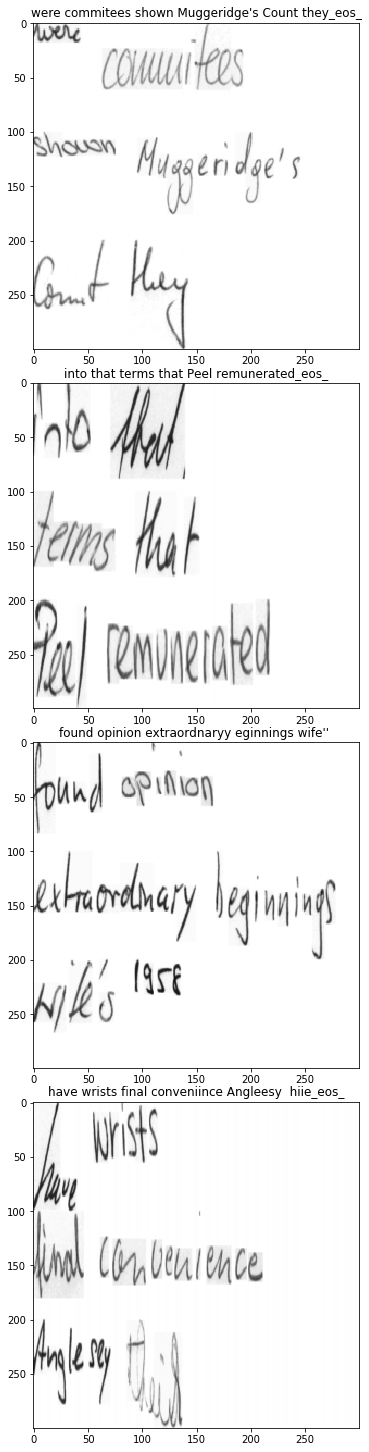

In [40]:
imgs = data.trn_ds.denorm(x)

fig, axes = plt.subplots(4,1, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    #t = char_label_text(y[i])     #=>  char indices
    p = word_label_text(res[:,i])
#     p = ctc_decode(res[:,i])
    ax=show_img(imgs[i], ax=ax, title=p)#t+' '+p)
    
plt.tight_layout(pad=0.1)

### Attention

In [41]:
# use for arch
attns = attns.permute(2,0,1)

In [47]:
# conv
k = 19  #16
def torch_scale_attns(attns):
    bs,sl,_ = attns.shape
    num = sz // k
    mod = attns.view(bs,sl,num,num)
    scaled = torch.nn.functional.interpolate(mod, size=sz)
    return scaled  #([bs, sl, sz, sz])

In [48]:
from scipy.ndimage import gaussian_filter

def g_filter(att):
    return gaussian_filter(att, sigma=k)

In [49]:
idx  = 1
img  = imgs[idx]
pred = res[:,idx]
img_attns = to_np(torch_scale_attns(attns)[idx])

RuntimeError: invalid argument 2: size '[40 x 45 x 15 x 15]' is invalid for input with 649800 elements at /opt/conda/conda-bld/pytorch_1535491974311/work/aten/src/TH/THStorage.cpp:84

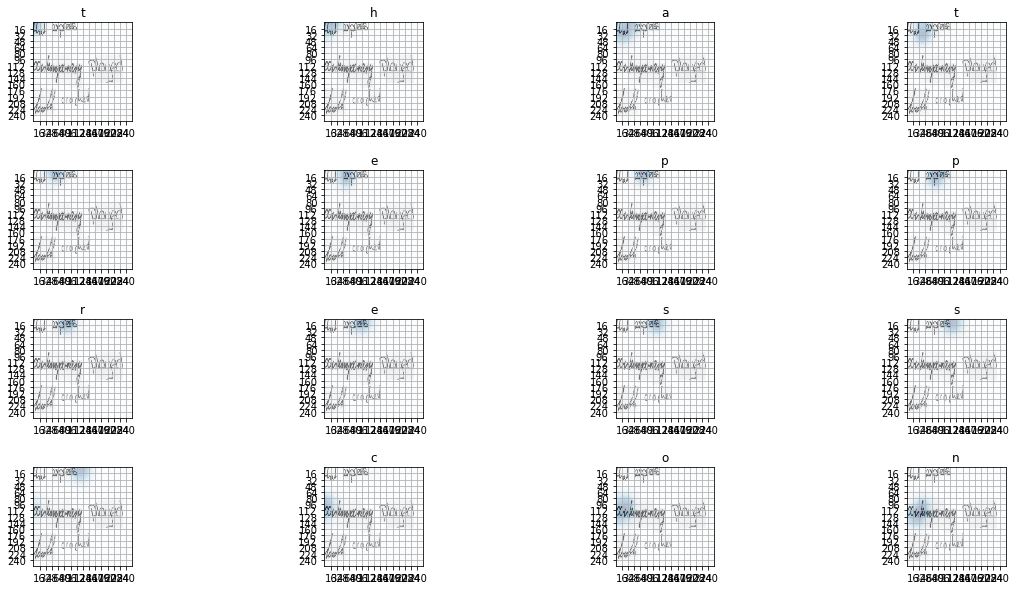

In [85]:
fig, axes = plt.subplots(4, 4, figsize=(20, 10), gridspec_kw={'hspace': 0.5})
for i,ax in enumerate(axes.flat):
    a = g_filter(img_attns[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', interpolation='nearest', alpha=0.3)
    
    # Attention
    ticks = np.arange(k, sz, k)
    ax.set_yticks(ticks, minor=False)
    ax.set_xticks(ticks, minor=False)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)

    ax.set_title(itos[pred[i].item()])

# Beam Search

In [86]:
idx=12

In [87]:
prob = preds[:, idx]
amts, idxs = torch.topk(prob[0], 5)
amts, idxs

(tensor([-18.0286, -20.7020, -21.7893, -21.8339, -22.1800],
        device='cuda:0', grad_fn=<TopkBackward>),
 tensor([  69,  121,    2, 1503,  456], device='cuda:0'))

In [88]:
[itos[i] for i in idxs]

['under', 'number', '_unk_', 'murder', 'winter']

In [77]:
word_stoi['deliberately']

3176

# Experiments

## MaxPool2d

In [20]:
pool = nn.MaxPool2d(2)

In [33]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
imgs = denorm(x)

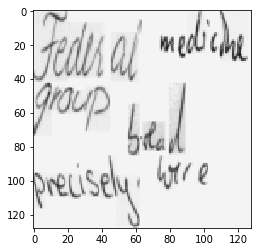

In [35]:
plt.imshow(imgs[0])

In [39]:
out = pool(x[0])

In [42]:
out_img = denorm(out[None])

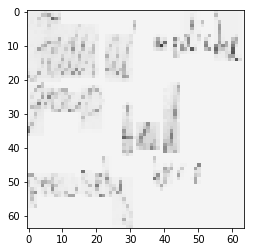

In [47]:
plt.imshow(out_img[0])